In [1]:
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import DataStore
from gammapy.maps import MapAxis, RegionGeom
from gammapy.makers import SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, WobbleRegionsFinder
from gammapy.datasets import Datasets
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from regions import CircleSkyRegion, PointSkyRegion
from gammapy.datasets import SpectrumDataset
import glob 
from gammapy.data import Observation, Observations
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u

In [2]:
# FINDING BACK DL3 FILES 

all_obs = []
for run in sorted(glob.glob("../../lst-school/DL3/Mrk421/dl3_LST-1.Run*.fits.gz")):
    print(run)
    obs = Observation.read(run)
    all_obs.append(obs)

../../lst-school/DL3/Mrk421/dl3_LST-1.Run17209.fits.gz
../../lst-school/DL3/Mrk421/dl3_LST-1.Run17210.fits.gz
../../lst-school/DL3/Mrk421/dl3_LST-1.Run17211.fits.gz


In [62]:
# USE OF GAMMAPY METHOD TO EXTRACT COUNTS

target_position = SkyCoord("11h04m27.3s +38d12m32s", frame="icrs")
on_region = PointSkyRegion(center=target_position)
energy_axis = MapAxis.from_energy_bounds("0.1 TeV", "10 TeV", nbin=10, per_decade=False, name="energy")
energy_axis_true = MapAxis.from_energy_bounds("0.05 TeV", "20 TeV", nbin=10, per_decade=False, name="energy_true")
maker = SpectrumDatasetMaker(selection=["counts", "exposure", "edisp"])
region_finder = WobbleRegionsFinder(n_off_regions=2)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)



In [63]:
#TIME BINNING 

t0 = all_obs[0].tstart 
print(t0) 
duration = 200* u.s
n_time_bins = 6
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]
print(len(time_intervals)) 


60430.912170285046
5


In [64]:
# CREATE SHORTER OBSERVATIONS WITH THE TIME BINNING 

short_observations = []

for obs in all_obs:    
    for interval in time_intervals:
        obs_in_bin = obs.select_time(interval)
        if len(obs_in_bin.events.table) > 0:
            short_observations.append(obs_in_bin)

short_observations = Observations(short_observations)

print(f"Number of short observations : {len(short_observations)}\n")


Number of short observations : 6



In [86]:
# EXTRACT COUNTS, ENERGIES AND TIMES FROM THE NEW SAMPLE OF SHORT OBSERVATIONS

datasets = []
times_mjd = []

t_ref = short_observations[0].tstart
times_range = []
energy_range = []
for obs in short_observations:
    geom = RegionGeom.create(region=on_region, axes=[energy_axis])
    dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)
    times = (obs.events.time - t_ref).to_value(u.s)
    times_range.append(times)
    energies = obs.events.energy.to(u.GeV).value
    energy_range.append(energies) 
    dataset = maker.run(dataset, obs)
    dataset = bkg_maker.run(dataset, obs)
    datasets.append(dataset)

[120.18119872  25.45850053  26.14386625 ...  42.82735313  39.64192068
  51.35222257]
[146.445008    54.75071113  74.0918236  ...  71.43278764  26.02044456
  25.54407576]
[ 73.03475194  50.32249155 121.54585506 ...  81.03133619  79.01266211
  59.34849003]
[64.64046089 59.93097397 71.22317392 ... 24.05478398 70.51176819
 41.29254402]
[28.3942029  73.41214909 26.40017081 ... 37.88785426 45.48085611
 47.46959377]
[ 33.49530783  27.1091284   63.62978715 ... 110.00460013  64.90700064
  37.82106729]


In [90]:
all_energies = np.concatenate(energy_range) *u.GeV
all_times = np.concatenate(times_range) * u.s

print(all_times.size, all_energies.size) 

1291784 1291784


In [91]:
# COUNTS GRILL 

counts_on_2d = np.array([
    dataset.counts.data.flatten()
    for dataset in datasets
])

counts_off_2d = np.array([
    dataset.background.data.flatten()
    for dataset in datasets
])
print(counts_on_2d.shape)
print(counts_off_2d.shape)


(6, 10)
(6, 10)


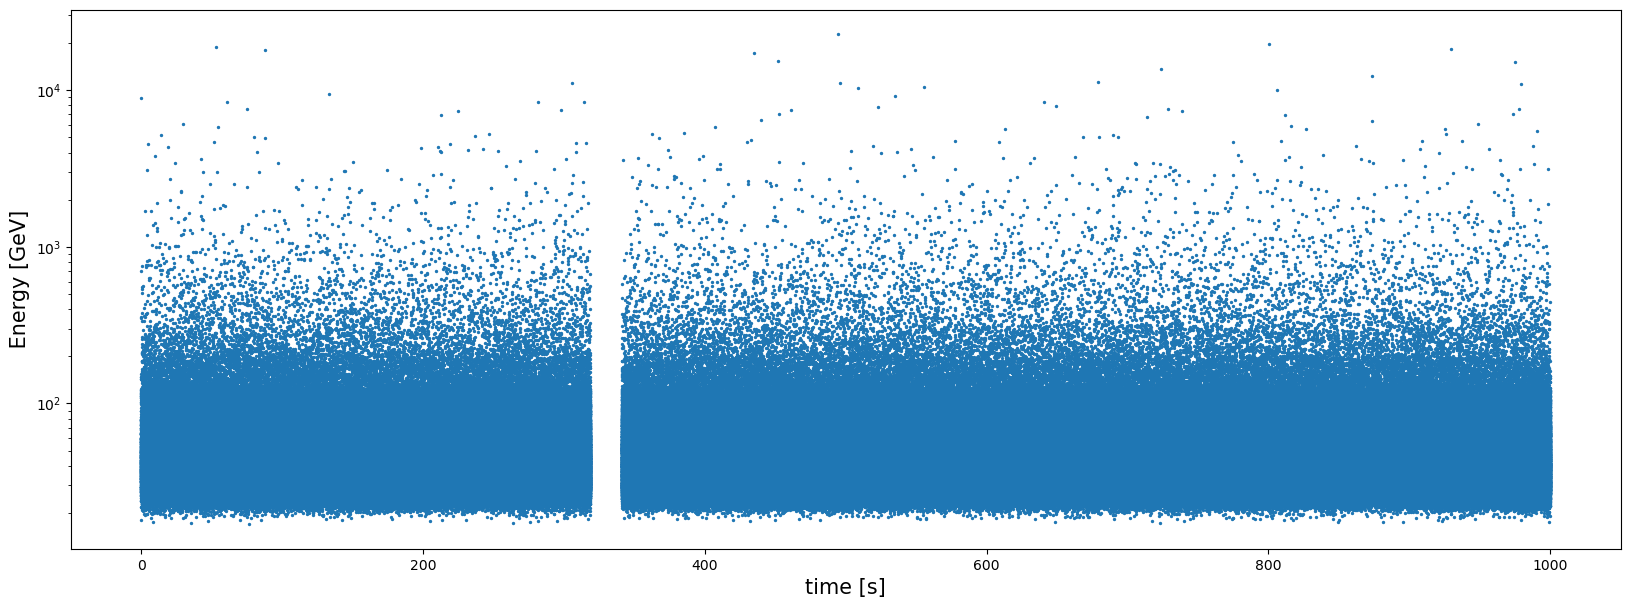

In [92]:
# PLOT ENERGY VS TIME

fig, ax = plt.subplots( 1,1,figsize=(20,7))

plt.ylabel(r' Energy [GeV] ',size=15)
plt.xlabel('time [s]',size=15)

plt.scatter( all_times, all_energies, s=2) 
plt.yscale('log')

<ErrorbarContainer object of 3 artists>

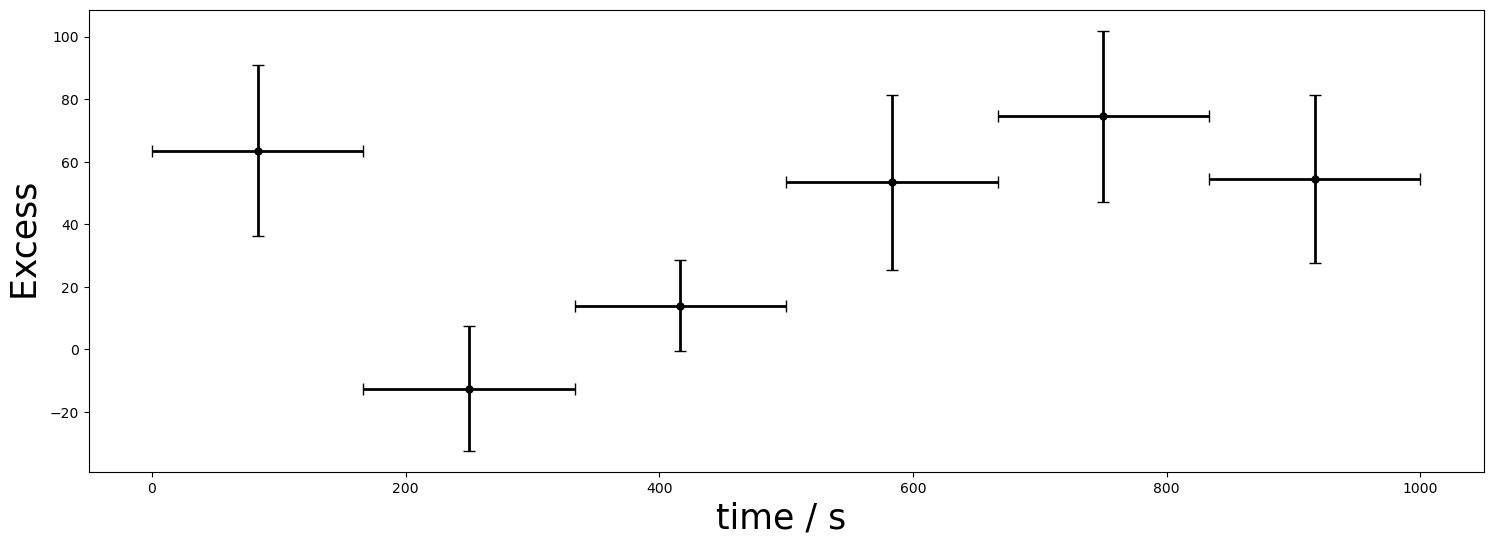

In [97]:
# PLOT LIGHT CURVE 

t_prime = np.linspace(all_times[0]*u.s, all_times[-1]*u.s, len(short_observations)+1  ) 
E_prime = np.geomspace(  30*u.GeV, 10*u.TeV, 11)

binwidth       = t_prime[1:]-t_prime[:-1]
bincenters     = (t_prime[1:]+t_prime[:-1])/2
LC_intr        = (counts_on_2d.sum(axis=1) -counts_off_2d.sum(axis=1)) 
LC_intr_unc    = np.sqrt( (counts_on_2d.sum(axis=1) + counts_off_2d.sum(axis=1)) )

rel_unc_per_time_bin = LC_intr_unc/LC_intr
rel_unc_per_time_bin[np.isnan(rel_unc_per_time_bin)] = 0

fig, ax = plt.subplots( 1,1,figsize=(18,6))

ax.set_ylabel(r' Excess ',fontsize=25)
ax.set_xlabel('time / s ',fontsize=25)
ax.errorbar(bincenters.value, LC_intr, LC_intr_unc ,binwidth.value/2,fmt='o', elinewidth=2, markersize=5, capsize=4,c='k')

In [98]:
# SAVE IN NUMPY ARRAY

np.save("results/ON_counts.npy", counts_on_2d)
np.save("results/OFF_counts.npy", counts_off_2d)